In [24]:
display("text/html", "<style>.container { width:100% !important; }</style>")

In [25]:
using Random, Distributions, Statistics, DataFrames, VegaLite, Plots
Random.seed!(10)

TaskLocalRNG()

In [27]:
using Random
using Distributions
using Statistics
# m - number of days
# s - reorder point
# S - target warehouse volume
function simulateOneRun(m, s, S;
    h = 0.1, #storage cost
    c = 4.0, #unit profit
    p = 0.75, #probability of delivery
    K = 100, # fixed order cost
    k = 1.0, # variable order cost
    init_S = 100, #initial warehouse level
    average_demand = 20)
    Xⱼ = init_S
    local Yj
    profit = 0.0
    lost_orders = 0.0
    warehouse_levels = Int[]
    #pois = Distributions.Poisson(average_demand)
    normal=Distributions.Normal(average_demand,5)
    for day in 1:m
        if Xⱼ < s
            if rand() < p
                profit -= K + (S-Xⱼ)*k
                Xⱼ = S
            end
        end
        push!(warehouse_levels, Xⱼ)
        #demand = rand(pois)
        demand = round.(Int, rand(normal))
        sales = min(Xⱼ, demand)
        Xⱼ -= sales
        @assert Xⱼ >= 0
        lost_order = demand - sales # failed to provide  
        @assert lost_order >= 0 
        profit += sales*c - (Xⱼ-sales)*h  # storage costs
        lost_orders += lost_order
        #koszt_jednostkowy_Stock_outu to wtedy bez wag 
        # one_obj = 0.75 * profit + 0.25 * lost_orders * koszt_jednostkowy_Stock_outu 
        # wtedy kiedy wybieramy jedna opcje np logistyke
    end
    
    (profit=profit, lost_orders=lost_orders,
        warehouse_levels=warehouse_levels) #,one_obj
end

simulateOneRun (generic function with 1 method)

In [28]:
function run_sims(m,s,S,N=100)
    df = DataFrame(simulateOneRun(m,s,S) for n in 1:N)
    (
        m=m,
        s=s,
        S=S,
        N=N,
        profit_mean = mean(df.profit),
        profit_std = std(df.profit),
        lost_mean = mean(df.lost_orders),
        lost_std = std(df.lost_orders)
    )
end

run_sims (generic function with 2 methods)

In [29]:
# Wartości początkowe dla s,S
using Random
Random.seed!(10)
df = DataFrame(run_sims(30,s,S,1000)
    for S in 100:100:1000, s in 20:10:50 if S > s )
best_row = argmax(df.profit_mean)
df[best_row,:]

Row,m,s,S,N,profit_mean,profit_std,lost_mean,lost_std
,Int64,Int64,Int64,Int64,Float64,Float64,Float64,Float64
12,30,30,200,1000,1275.55,115.325,7.246,13.9784


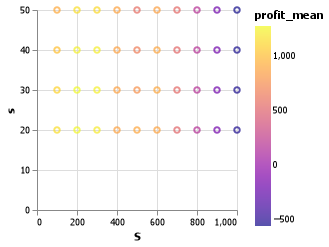

In [30]:
#using VegaLite
df |> @vlplot(:point, x=:S, y=:s, color={:profit_mean, scale={scheme=:plasma}})

In [31]:
# zaweżenie przedziałów w s i S 
# using Random
Random.seed!(10)
df = DataFrame(run_sims(30,s,S,1000)
    for S in 100:10:350, s in 10:5:50 if S > s )
best_row = argmax(df.profit_mean)
df[best_row,:]

Row,m,s,S,N,profit_mean,profit_std,lost_mean,lost_std
,Int64,Int64,Int64,Int64,Float64,Float64,Float64,Float64
61,30,20,180,1000,1308.8,106.534,14.089,18.2738


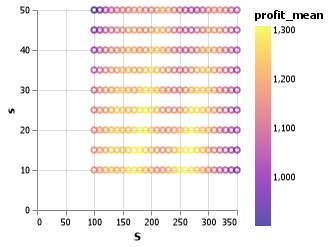

In [32]:
# Możemy zaobserowować że jest wiecęj dobrych punktów punktów gdzie posiadamy duże wartości profit_mean.
using VegaLite
df |> @vlplot(:point, x=:S, y=:s, color={:profit_mean, scale={scheme=:plasma}})

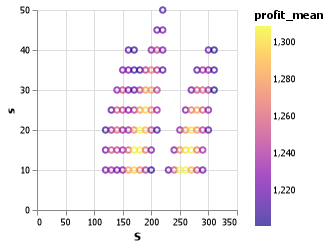

In [33]:
# Sprawdzamy te  wartości które mają wartości profit_mean ponad 1200.
filtered_df_1200 = filter(row -> row.profit_mean >= 1200, df)
using VegaLite
filtered_df_1200 |> @vlplot(:point, x=:S, y=:s, color={:profit_mean, scale={scheme=:plasma}})

Możemy zaobserować nasz maksymalny profit_mean=1308 dla parametrów s=20 i S=180 ale rownież posiadamy kilka innych rownie dobrych wartości. Sprawdźmy więc inne punkty:

In [34]:
filtered_df = filter(row -> row.s == 15 && row.S == 270, df)

Row,m,s,S,N,profit_mean,profit_std,lost_mean,lost_std
,Int64,Int64,Int64,Int64,Float64,Float64,Float64,Float64
1,30,15,270,1000,1305.82,126.717,13.069,16.7615


In [35]:
filtered_df = filter(row -> row.s == 10 && row.S == 250, df)

Row,m,s,S,N,profit_mean,profit_std,lost_mean,lost_std
,Int64,Int64,Int64,Int64,Float64,Float64,Float64,Float64
1,30,10,250,1000,1306.99,120.282,21.379,19.5673


Możemy zaobserwować że wartości s=15 i S=270 generują nam profit_mean=1305 przymniejszym lost_mean=13.06 co może być naszym 2 wyborem. <br />
Jeśli zdecydujemy się wybrać trochę mniejszy profit_mean to będziemy mieli rownież mniejszy lost_mean co wydaje się rownież dobrym wynikiem. 

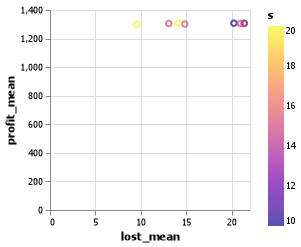

In [36]:
using VegaLite
filtered_df_1300 = filter(row -> row.profit_mean >= 1300, df)
filtered_df_1300 |> @vlplot(:point, x=:lost_mean, y=:profit_mean, color={:s, scale={scheme=:plasma}})

In [37]:
sort!(filtered_df_1300, :lost_mean)

Row,m,s,S,N,profit_mean,profit_std,lost_mean,lost_std
,Int64,Int64,Int64,Int64,Float64,Float64,Float64,Float64
1,30,20,270,1000,1300.49,123.039,9.54,14.9159
2,30,15,270,1000,1305.82,126.717,13.069,16.7615
3,30,20,180,1000,1308.8,106.534,14.089,18.2738
4,30,15,260,1000,1301.73,122.841,14.833,17.4992
5,30,10,260,1000,1307.82,126.708,20.225,19.7092
6,30,15,180,1000,1305.66,125.596,20.943,21.1076
7,30,15,170,1000,1305.45,108.113,21.344,21.4889
8,30,10,250,1000,1306.99,120.282,21.379,19.5673


W powyższej tabeli możemy zaobserwować wszsytkie najlepsze wyniki.  

In [38]:
zysk  = (1308.8 - 1275.55) * 12
print("Średni profit roczny = ",zysk)

Średni profit roczny = 399.0

In [39]:
procent = (399 / (1275.55 * 12)) * 100
procent = round(procent, digits=2)
print("Średni roczny procent profitu = ", procent, "%")

Średni roczny procent profitu = 2.61%

Przeprowadź Analizę wrażliwości: zmiana parametrów a rozwiązanie optymalne (RO)
– czy zmiana parametru (np.wzrost ceny produktu o 5%/ wzrost wynagrodzenia godzinowego ) spowoduje zmianę R.O., czy ciągle ono pozostanie takie samo?


In [41]:
Random.seed!(10)
using Random
using Distributions
using Statistics

function simulateOneRun(m, s, S;
    h = 0.1, #storage cost
    c = 4.0, #unit profit
    p = 0.75, #probability of delivery
    K = 100, # fixed order cost
    k = 1.0, # variable order cost
    init_S = 100, #initial warehouse level
    average_demand = 20)
    Xⱼ = init_S
    local Yj
    profit = 0.0
    lost_orders = 0.0
    warehouse_levels = Int[]
    #pois = Distributions.Poisson(average_demand)
    normal=Distributions.Normal(average_demand,5)
    for day in 1:m
        if Xⱼ < s
            if rand() < p
                profit -= K + (S-Xⱼ)*k
                Xⱼ = S
            end
        end
        push!(warehouse_levels, Xⱼ)
        #demand = rand(pois)
        demand = round.(Int, rand(normal))
        sales = min(Xⱼ, demand)
        Xⱼ -= sales
        @assert Xⱼ >= 0
        lost_order = demand - sales # failed to provide  
        @assert lost_order >= 0 
        profit += sales*c - (Xⱼ-sales)*h
        lost_orders += lost_order
    end
    
    (profit=profit, lost_orders=lost_orders,
        warehouse_levels=warehouse_levels)
end

simulateOneRun (generic function with 1 method)

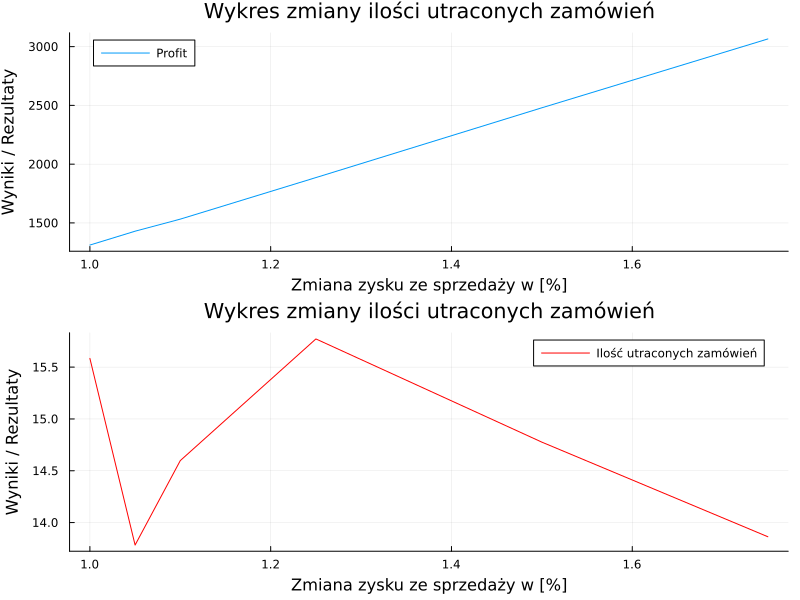

In [48]:
using Plots
Plots.gr(size=(800, 600))
Random.seed!(10)
# Parametry symulacji
m = 30
s = 20
S = 180
h = 0.1
c = 4.0
p = 0.75
K = 100
k = 1.0
init_S = 100
average_demand = 20

# Inicjalizacja wyników symulacji
profit_mean = zeros(Float64, 6)
lost_mean = zeros(Float64, 6)


# Symulacja i obliczenie wyników
for (i, wage) in enumerate([1, 1.05, 1.1, 1.25, 1.5, 1.75])
    results = DataFrame(simulateOneRun(m, s, S, h=h, c=c*wage, p=p, K=K, k=k, init_S=init_S, average_demand=average_demand) for n in 1:1000)
    profit_mean[i] = mean(results.profit)
    lost_mean[i] = mean(results.lost_orders)
end
pr = plot(layout = (2, 1))
plot!(pr[1],[1, 1.05, 1.1, 1.25, 1.5, 1.75], profit_mean, label="Profit")
xlabel!("Zmiana zysku ze sprzedaży w [%]")
ylabel!("Wyniki / Rezultaty")
title!("Wykres zmiany profitu w zależności od zmiany zysku ze sprzedaży")
plot!(pr[2],[1, 1.05, 1.1, 1.25, 1.5, 1.75], lost_mean, label="Ilość utraconych zamówień",linecolor = :red)
xlabel!("Zmiana zysku ze sprzedaży w [%]")
ylabel!("Wyniki / Rezultaty")
title!("Wykres zmiany ilości utraconych zamówień")

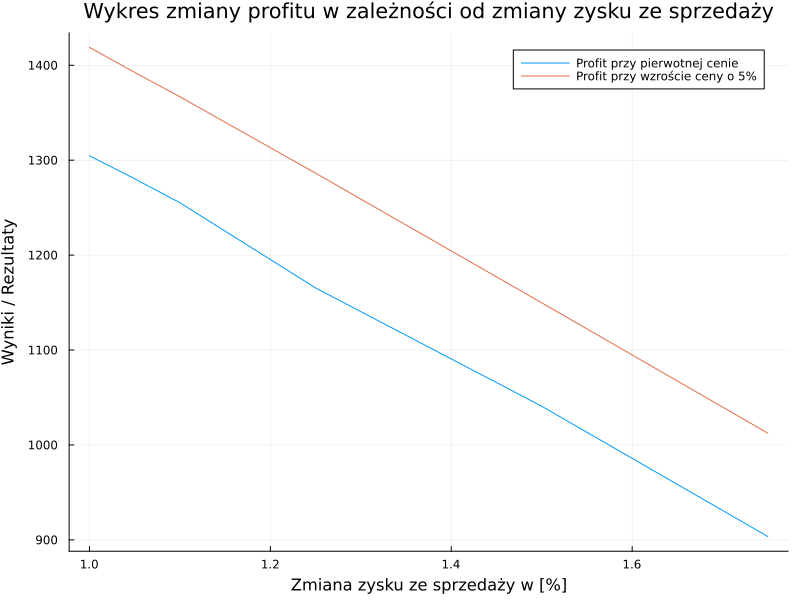

In [55]:
# Inicjalizacja wyników symulacji
profits_payroll_change_1_00 = zeros(Float64, 6)
lost_orders_payroll_change_1_00 = zeros(Float64, 6)

# Symulacja i obliczenie wyników
for (i, payroll_change) in enumerate([1, 1.05, 1.1, 1.25, 1.5, 1.75])
    results = DataFrame(simulateOneRun(m, s, S, h=h, c=c, p=p, K=K, k=k*payroll_change, init_S=init_S, average_demand=average_demand) for n in 1:1000)
    profits_payroll_change_1_00[i] = mean(results.profit)
    lost_orders_payroll_change_1_00[i] = mean(results.lost_orders)
end

# Inicjalizacja wyników symulacji
profits_payroll_change_1_05 = zeros(Float64, 6)
lost_orders_payroll_change_1_05 = zeros(Float64, 6)

# Symulacja i obliczenie wyników
for (i, payroll_change) in enumerate([1, 1.05, 1.1, 1.25, 1.5, 1.75])
    results = DataFrame(simulateOneRun(m, s, S, h=h, c=c*1.05, p=p, K=K, k=k*payroll_change, init_S=init_S, average_demand=average_demand) for n in 1:1000)
    profits_payroll_change_1_05[i] = mean(results.profit)
    lost_orders_payroll_change_1_05[i] = mean(results.lost_orders)
end

plot([1, 1.05, 1.1, 1.25, 1.5, 1.75], profits_payroll_change_1_00, label="Profit przy pierwotnej cenie")
plot!([1, 1.05, 1.1, 1.25, 1.5, 1.75], profits_payroll_change_1_05, label="Profit przy wzroście ceny o 5%")
xlabel!("Zmiana zysku ze sprzedaży w [%]")
ylabel!("Wyniki / Rezultaty")
title!("Wykres zmiany profitu w zależności od zmiany zysku ze sprzedaży")

In [50]:
profits_payroll_change_1_00

6-element Vector{Float64}:
 1305.9432
 1282.1131500000001
 1251.2165
 1177.9995499999998
 1027.7781
  903.0079499999999

In [52]:
Random.seed!(10)

# Inicjalizacja wyników symulacji
profits_payroll_change_1_10 = zeros(Float64, 6)
lost_orders_payroll_change_1_10 = zeros(Float64, 6)
 
# Symulacja i obliczenie wyników
for (i, payroll_change) in enumerate([1, 1.05, 1.1, 1.25, 1.5, 1.75])
    results = DataFrame(simulateOneRun(m, s, S, h=h, c=c*1.1, p=p, K=K, k=k*payroll_change, init_S=init_S, average_demand=average_demand) for n in 1:1000)
    profits_payroll_change_1_10[i] = mean(results.profit)
    lost_orders_payroll_change_1_10[i] = mean(results.lost_orders)
end

# Inicjalizacja wyników symulacji
profits_payroll_change_1_20 = zeros(Float64, 6)
lost_orders_payroll_change_1_20 = zeros(Float64, 6)

# Symulacja i obliczenie wyników
for (i, payroll_change) in enumerate([1, 1.05, 1.1, 1.25, 1.5, 1.75])
    results = DataFrame(simulateOneRun(m, s, S, h=h, c=c*1.2, p=p, K=K, k=k*payroll_change, init_S=init_S, average_demand=average_demand) for n in 1:1000)
    profits_payroll_change_1_20[i] = mean(results.profit)
    lost_orders_payroll_change_1_20[i] = mean(results.lost_orders)
end

# Inicjalizacja wyników symulacji
profits_payroll_change_1_50 = zeros(Float64, 6)
lost_orders_payroll_change_1_50 = zeros(Float64, 6)

# Symulacja i obliczenie wyników
for (i, payroll_change) in enumerate([1, 1.05, 1.1, 1.25, 1.5, 1.75])
    results = DataFrame(simulateOneRun(m, s, S, h=h, c=c*1.5, p=p, K=K, k=k*payroll_change, init_S=init_S, average_demand=average_demand) for n in 1:1000)
    profits_payroll_change_1_50[i] = mean(results.profit)
    lost_orders_payroll_change_1_50[i] = mean(results.lost_orders)
end

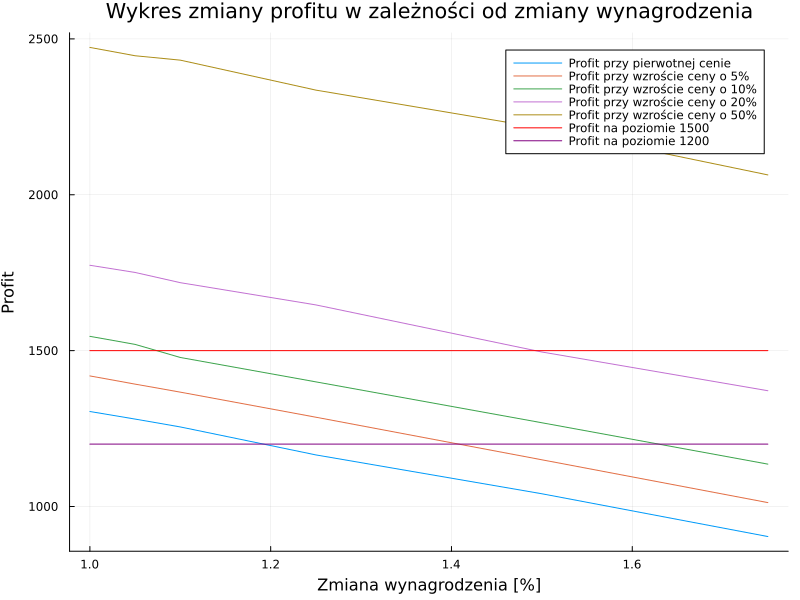

In [61]:


plot([1, 1.05, 1.1, 1.25, 1.5, 1.75], profits_payroll_change_1_00, label="Profit przy pierwotnej cenie")
plot!([1, 1.05, 1.1, 1.25, 1.5, 1.75], profits_payroll_change_1_05, label="Profit przy wzroście ceny o 5%")
plot!([1, 1.05, 1.1, 1.25, 1.5, 1.75], profits_payroll_change_1_10, label="Profit przy wzroście ceny o 10%")
plot!([1, 1.05, 1.1, 1.25, 1.5, 1.75], profits_payroll_change_1_20, label="Profit przy wzroście ceny o 20%")
plot!([1, 1.05, 1.1, 1.25, 1.5, 1.75], profits_payroll_change_1_50, label="Profit przy wzroście ceny o 50%")
plot!([1, 1.75], [1500, 1500], linecolor=:red, linewidth=1, label="Profit na poziomie 1500")
plot!([1, 1.75], [1200, 1200], linecolor=:purple, linewidth=1, label="Profit na poziomie 1200")
xlabel!("Zmiana wynagrodzenia [%]")
ylabel!("Profit")
title!("Wykres zmiany profitu w zależności od zmiany wynagrodzenia")

## Analiza ceteris-paribus dla 3 parametrów

In [ ]:
h = 0.1 storage_cost
p = 0.75 prob_of_delivery

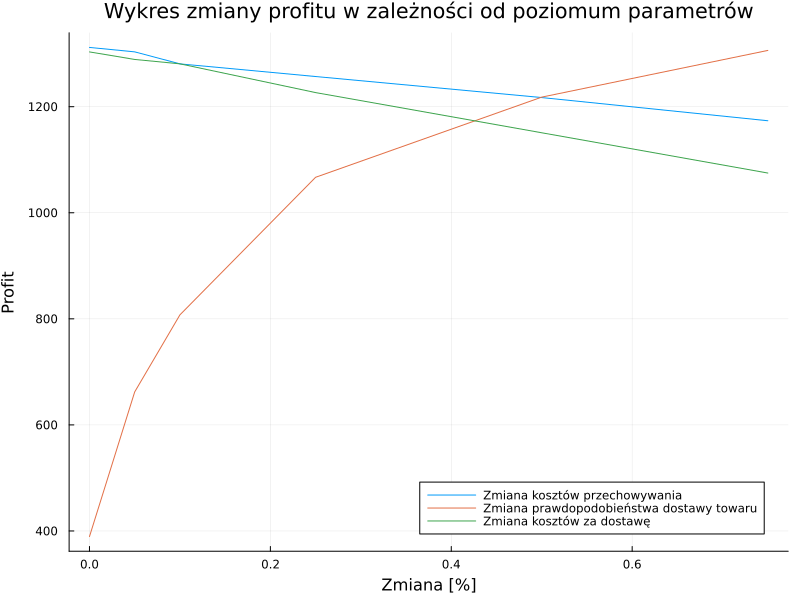

In [71]:
Random.seed!(10)
# Parametry symulacji
m = 30
s = 20
S = 180
h = 0.1
c = 4.0
p = 0.75
K = 100
k = 1.0
init_S = 100
average_demand = 20
storage_cost_change = zeros(Float64, 6)
prob_of_delivery_change = zeros(Float64, 6)
fixed_order_cost_change = zeros(Float64, 6)


# Symulacja i obliczenie wyników
for (i, storage_cost) in enumerate([0, 0.05, 0.1, 0.25, 0.5, 0.75])
    results = DataFrame(simulateOneRun(m, s, S, h=h*(storage_cost + 1), c=c, p=p, K=K, k=k, init_S=init_S, average_demand=average_demand) for n in 1:1000)
    storage_cost_change[i] = mean(results.profit)
end

for (i, prob_of_delivery) in enumerate([0, 0.05, 0.1, 0.25, 0.5, 0.75])
    results = DataFrame(simulateOneRun(m, s, S, h=h, c=c, p=prob_of_delivery, K=K, k=k, init_S=init_S, average_demand=average_demand) for n in 1:1000)
    prob_of_delivery_change[i] = mean(results.profit)
end

for (i, fixed_order_cost) in enumerate([0, 0.05, 0.1, 0.25, 0.5, 0.75])
    results = DataFrame(simulateOneRun(m, s, S, h=h, c=c, p=p, K=K*(1+fixed_order_cost), k=k, init_S=init_S, average_demand=average_demand) for n in 1:1000)
    fixed_order_cost_change[i] = mean(results.profit)
end



plot([0, 0.05, 0.1, 0.25, 0.5, 0.75], storage_cost_change, label="Zmiana kosztów przechowywania")
plot!([0, 0.05, 0.1, 0.25, 0.5, 0.75], prob_of_delivery_change, label="Zmiana prawdopodobieństwa dostawy towaru")
plot!([0, 0.05, 0.1, 0.25, 0.5, 0.75], fixed_order_cost_change, label="Zmiana kosztów za dostawę")
title!("Wykres zmiany profitu w zależności od poziomum parametrów")
xlabel!("Zmiana [%]")
ylabel!("Profit")

In [87]:
using DataFrames
Profit = storage_cost_change
koszt_przechowania_jednostki_towaru = [1, 1.05, 1.1, 1.25, 1.5, 1.75] .* 0.1
df = DataFrame(Profit = Profit, Koszt_przechowania_jednostki_towaru = koszt_przechowania_jednostki_towaru)

Row,Profit,Koszt_przechowania_jednostki_towaru
,Float64,Float64
1,1311.78,0.1
2,1303.41,0.105
3,1280.75,0.11
4,1256.9,0.125
5,1217.25,0.15
6,1173.51,0.175


In [88]:
using DataFrames
Profit = prob_of_delivery_change
Zmiana_pradopodobieństwa_dostawy = [0, 0.05, 0.1, 0.25, 0.5, 0.75]
df = DataFrame(Profit = Profit, Pradopodobieństwa_dostawy = Zmiana_pradopodobieństwa_dostawy)

Row,Profit,Pradopodobieństwa_dostawy
,Float64,Float64
1,389.446,0.0
2,662.208,0.05
3,807.51,0.1
4,1066.92,0.25
5,1218.09,0.5
6,1306.15,0.75


In [82]:
using DataFrames
Profit = fixed_order_cost_change
Zmiana_kosztow_dostawy = [1, 1.05, 1.1, 1.25, 1.5, 1.75] .* 100
df = DataFrame(Profit = Profit, Zmiana_kosztow_dostawy = Zmiana_kosztow_dostawy)

Row,Profit,Zmiana_kosztow_dostawy
,Float64,Float64
1,1303.32,100.0
2,1289.1,105.0
3,1280.83,110.0
4,1226.6,125.0
5,1150.85,150.0
6,1074.9,175.0
